## Train, Evaluate and Visualize the Word Embeddings
In this Notebook we detail the process of how to train a word2vec model on the Medline Abstracts and obtaining the word embeddings for the biomedical terms. This is the first step towards building an Entity Extractor. We are using the Spark's <a href = "https://spark.apache.org/mllib/">MLLib</a> package to train the word embedding model. We also show how you can test the quality of the embeddings by an intrinsic evaluation task along with visualization.
<br>
The Word Embeddings obtained from spark are stored in parquet files with gzip compression. In the next notebook we show how you can easily extract the word embeddings form these parquet files and visualize them in any tool of your choice.

<br> This notebook is divided into several sections, details of which are presented below.
<ol>
<li>Load the data into the dataframe and preprocess it.</li>
<li>Tokenize the data into words and train Word2Vec Model</li>
<li>Evaluate the Quality of the Word Embeddings by comparing the Spearman Correlation on a Human Annoted Dataset</li>
<li>Use PCA to reduce the dimension of the Embeddings to 2 for Visualization</li>
<li>Use t-SNE incombination with PCA to improve the Quality of the Visualizations </li>
</ol>

### Step 1

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.mllib.feature import Word2Vec
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import datetime

sqlContext = SQLContext(sc)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1500401104949_0008,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


<b> Setup the paths where the TSV files are located <b>

In [4]:
data_dir = "wasb:///medline_baseline/"
pubmed_tsvs = "wasb:///medline_baseline/1" 
pubmedTitAbs = "wasb:///medline_baseline/Articles/Title_Abstracts/"

### Step 2

### Read in Pubmed Abstracts from csv
<br> This cell iterates over all the parsed pubmed files and combines them into a single dataframe. <br>It then writes this new dataframe to a parquet file for faster access in Subsequent runs.<br><br>
Note: <ol><li>Ideally you should run the below cell only <b>once</b> and use the parquet file for subsequent runs.</li>
<li> This cell saves a parquet files after reading every 100 files. If this block fails for some reason, you can resume from the latest file.

In [5]:
timestart = datetime.datetime.now()
pubmedAbstracts = spark.read.csv(path=pubmed_tsvs, header=True, inferSchema=True, sep = "\t")

for i in range(2, 813):
    try:
        pubmed_tsvs_1 = data_dir + str(i)
        pubmedAbstracts_1 = spark.read.csv(path=pubmed_tsvs_1, header=True, inferSchema=True, sep = "\t")
        pubmedAbstracts = pubmedAbstracts.union(pubmedAbstracts_1)
        if i % 100 == 0:
            pubmedAbstracts.repartition(300).write.mode("overwrite").parquet(pubmedTitAbs + str(i))
            pubmedAbstracts_new = spark.read.parquet(pubmedTitAbs + str(i))
            pubmedAbstracts = pubmedAbstracts_new 
    except:
        print("Skipped"+str(i))

pubmedAbstracts.printSchema()
print(pubmedAbstracts.count())

pubmedAbstracts.select("title","abstract").repartition(300).write.mode("overwrite").parquet(pubmedTitAbs + "full")

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds() / 60, 2)
print ("Time taken to execute above cell: " + str(timedelta) + " mins");

Skipped753
Skipped755
Skipped761
Skipped766
Skipped767
Skipped778
Skipped779
Skipped780
Skipped786
Skipped795
Skipped798
Skipped799
root
 |-- abstract: string (nullable = true)
 |-- affiliation: string (nullable = true)
 |-- author: string (nullable = true)
 |-- country: string (nullable = true)
 |-- delete: boolean (nullable = true)
 |-- file_name: string (nullable = true)
 |-- issn_linking: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- medline_ta: string (nullable = true)
 |-- mesh_terms: string (nullable = true)
 |-- nlm_unique_id: string (nullable = true)
 |-- other_id: string (nullable = true)
 |-- pmc: string (nullable = true)
 |-- pmid: integer (nullable = true)
 |-- pubdate: string (nullable = true)
 |-- title: string (nullable = true)

23998617
Time taken to execute above cell: 44.07 mins

In [6]:
timestart = datetime.datetime.now()

## Read the data from Parquet File
pubmedTitAbsDF = spark.read.parquet("wasb:///medline_baseline/Articles/Title_Abstracts/full")

## Drop the abstracts and titles that donot have any content
pubmedTitAbsDF1 = pubmedTitAbsDF.select("abstract", "title").na.drop()

print(pubmedTitAbsDF1.count(), pubmedTitAbsDF.count())

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds() / 60, 2)
print ("Time taken to execute above cell: " + str(timedelta) + " mins");

(14582320, 23998617)
Time taken to execute above cell: 1.08 mins

In [7]:
pubmedTitAbsDF2 = pubmedTitAbsDF1

### Step 3 (Optional)

### Filtering of Abstracts
<br> This step is totally optional. It filters out abstracts that do not contain any word that you care about. You can specify a vocabulary for words you would like to see the embeddings for in the below cell and the subsequent cell will filter the abstracts based on your vocabulary.

<b> Load dictionary for Drugs and Diseases for filtering</b>

In [108]:
##Uncomment if you require filtering
'''
vocab = "wasb:///HdiSamples/HdiSamples/Pubmed/words_rel.txt"
vocab_df = spark.read.csv(path = words_rel, header=True, inferSchema=True, sep = "\t")
vocab_df.printSchema()

# REGISTER words_rel_df DF IN SQL-CONTEXT
vocab_df.createOrReplaceTempView("dict_words")
spark.sql("show tables").show()
'''

root
 |-- words: string (nullable = true)

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |     dict_words|       true|
|        |      test_dict|       true|
|        |       word2vec|       true|
+--------+---------------+-----------+

<b> Filter the Abstracts based on the dictionary loaded above</b>
<br> This will help to filter out abstracts that donot contain words that you care about
<br> Its an optional preprocessing step

In [109]:
##Uncomment if you require filtering
'''from pyspark.sql.functions import regexp_replace, trim, col, lower, udf
from pyspark.sql.types import *
timestart = datetime.datetime.now()
words = []
for row in vocab_df.collect():
    words.append(row['words'].lower())

pubmedTitAbsDF1.printSchema()

def intersect(row):
    # convert each word in lowercase
    if row is None:
        return False
    row = [x.lower() for x in row.split()]
    return True if set(row).intersection(set(words)) else False

filterUDF = udf(intersect, BooleanType())

pubmedTitAbsDF2 = pubmedTitAbsDF1.where(filterUDF(pubmedTitAbsDF1.abstract))

a = pubmedTitAbsDF1.count()
b = pubmedTitAbsDF2.count()
print(a, b, a-b)

pubmedTitAbsDF2.repartition(200).write.mode("overwrite").parquet(filter_file)

filter_file = "wasb:///HdiSamples/HdiSamples/Pubmed/filtered_df"
pubmedTitAbsDF2 = spark.read.parquet(filter_file)

##See the Schema of the DF
pubmedTitAbsDF2.printSchema()

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds() / 60, 2)
print ("Time taken to execute above cell: " + str(timedelta) + " mins");
'''

root
 |-- abstract: string (nullable = true)
 |-- title: string (nullable = true)

In [8]:
pubmedTitAbsDF2.count()

14582320

### Step 4

<b> Preprocess the Abstracts </b><br>
We do some basic pre-processing like converting words to lowercase and removing separators other than - and _. <br>
We then split the words into tokens. 

In [9]:
from pyspark.sql.functions import regexp_replace, trim, col, lower, udf
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover

timestart = datetime.datetime.now()

tokenizer = Tokenizer(inputCol="abstractNew", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtWords")

# Convert the content to Lower Case
pubmedTitAbsDF2 = pubmedTitAbsDF2.withColumn("abstractNew", lower(col("abstract")))
pubmedTitAbsDF2 = pubmedTitAbsDF2.withColumn("abstractNew", regexp_replace("abstractNew", '[^\w-_ ]', ""))

# Tokenize the Abstracts
pubmedTitAbsDF4 = tokenizer.transform(pubmedTitAbsDF2)

pubmedTitAbsDF5 = pubmedTitAbsDF4

print(pubmedTitAbsDF5.count())
print(pubmedTitAbsDF5.head())
print(pubmedTitAbsDF5.printSchema())

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds() / 60, 2)
print ("Time taken to execute above cell: " + str(timedelta) + " mins");

14582320
Row(abstract=u'The effect of a single administration of d-amphetamine (0.32 mg/kg, s.c.) upon latent inhibition (LI) in a one-session pre-exposure and conditioning procedure was investigated in rats in a conditioned emotional response paradigm. It was found that amphetamine attenuated LI. The effects could not be attributed to differences in unconditioned suppression nor to differences in response rates between the experimental groups. These results support the observations of Dunn and suggest that the disruption of LI may not depend upon a complex interaction between changes in neuronal processes consequent upon repetitive amphetamine administration and the schedule with which the drug is administered during the experimental procedure.', title=u'A single administration of d-amphetamine prior to stimulus pre-exposure and conditioning attenuates latent inhibition.', abstractNew=u'the effect of a single administration of d-amphetamine 032 mgkg sc upon latent inhibition li in a o

<br><br><b> Load the test data for Intrinsic Evaluation </b>
<br>Test Set Details
<ul>
<li>Contains 588 concept (drugs, diseases, symptoms) pairs manually rated for semantic relatedness.</li>
<li>The Ratings provided are on an arbitrary scale.</li>
</ul>
<br>A few details about the Spearman correlation
<ul>
<li>Spearman Correlation (ρ) is a nonparametric measure of rank correlation. </li>
<li>It assesses how well the relationship between two variables(pairs ranked by humans VS pairs ranked by our model) can be described using a monotonic function. </li>
<li>It compares ranking between variables regardless of their scale</li>
</ul>
<br>

#### Load the Test Set

In [10]:
#Change the path to the location of UMNSRS-rel.txt
UMNSRS_rel_file = "wasb:///Path to/UMNSRS-rel.txt"
UMNSRS_rel = spark.read.csv(path = UMNSRS_rel_file, header=True, inferSchema=True, sep = "\t")
UMNSRS_rel.printSchema()

# REGISTER UMNSRS_rel DF IN SQL-CONTEXT
UMNSRS_rel.createOrReplaceTempView("dict")
spark.sql("show tables").show()

root
 |-- word1: string (nullable = true)
 |-- word2: string (nullable = true)
 |-- score: double (nullable = true)

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |           dict|       true|
+--------+---------------+-----------+

<b> Load the words in from the test set </b>
<br>This loads a dictionary of all the words present in the test set. We'll use this later while evaluating the word embeddings.


In [11]:
#Change the path to the location of Test_words.txt
test_words_file = "wasb:///Path to Test_words.txt"
test_words = spark.read.csv(path = test_words_file, header=True, inferSchema=True, sep = "\n")
test_words.printSchema()

# REGISTER DF IN SQL-CONTEXT
test_words.createOrReplaceTempView("test_dict")
spark.sql("show tables").show()

root
 |-- words_test: string (nullable = true)

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |           dict|       true|
|        |      test_dict|       true|
+--------+---------------+-----------+

### Step 5

#### Train <a href = "https://spark.apache.org/docs/2.1.1/api/java/org/apache/spark/mllib/feature/Word2Vec.html"> Word2Vec Model</a> (it takes some time to run depending on the data size)
<ul>
<li> It runs in slighlty over 15 minutes when run on 15 million abstracts with a window size of 5, vector size of 50 and mincount of 400.</li><li> This performance is on a spark cluster with 11 worker nodes each with 4 cores.</li>
<li> The parameter values of 5 for window size, 50 for vector size and mincount of 400 work well for the Entity Recognition Task.</li><li> However optimal performance (Rho = 0.5632) during the Intrinsic Evaluation is achieved with a window size of 30, vector size of 100 and mincount of 400. </li><li>This difference can be attributed to the fact that a bigger window size does not help the Entity Recognition task and a simpler model is preferred.</li>
<li> To speed up the evaluation of word2vec change number of partitions to a higher value (&lt; number of cores available), but this may decrease the accuracy o fthe model.
</ul>
<br> For the cell below we are using a cluster size of 4 worker nodes each with 4 cores. 

In [12]:
timestart = datetime.datetime.now()
from pyspark.ml.feature import Word2Vec
model = None
vector_size = 50
word2Vec = Word2Vec(windowSize=5, vectorSize = vector_size, minCount=1000, numPartitions=10, inputCol="words", outputCol="result")
model = word2Vec.fit(pubmedTitAbsDF5)

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds() / 60, 2)
model.getVectors().count()
print ("Time taken to execute above cell: " + str(timedelta) + " mins");

Time taken to execute above cell: 118.01 mins

Save the model for future use

In [117]:
#Change the path to the location where you want to save your model
model_file = "wasb:///Path to Model/w2vmodel_entiredataset_vs_50_ws_5_mc_1000_model.bin"
model.save(model_file)

<b> Manually Evaluate Similar words by getting nearest neighbours </b>

In [13]:
model.findSynonyms("cancer", 20).select("word").head(20) #Returns types of Cancers, hormones responsible for Cancer etc.

[Row(word=u'crc'), Row(word=u'colorectal'), Row(word=u'eoc'), Row(word=u'breast'), Row(word=u'hormone-refractory'), Row(word=u'nsclc'), Row(word=u'crpc'), Row(word=u'prostate'), Row(word=u'cancers'), Row(word=u'early-stage'), Row(word=u'carcinoma'), Row(word=u'adenocarcinoma'), Row(word=u'her2-positive'), Row(word=u'head-and-neck'), Row(word=u'hcc'), Row(word=u'metastatic'), Row(word=u'hnscc'), Row(word=u'gbc'), Row(word=u'mcrc'), Row(word=u'tnbc')]

In [14]:
model.findSynonyms("brain", 20).select("word").head(20)# Returns Different Parts of the Brain

[Row(word=u'cerebrum'), Row(word=u'cerebellum'), Row(word=u'forebrain'), Row(word=u'neocortex'), Row(word=u'cerebrocortical'), Row(word=u'hippocampi'), Row(word=u'brains'), Row(word=u'white-matter'), Row(word=u'hippocampus'), Row(word=u'striatum'), Row(word=u'demyelinated'), Row(word=u'diencephalon'), Row(word=u'striatal'), Row(word=u'gerbil'), Row(word=u'infarcted'), Row(word=u'hypoxic-ischemic'), Row(word=u'retina'), Row(word=u'neurohypophysis'), Row(word=u'telencephalon'), Row(word=u'neocortical')]

<b>Store the word vectors in a SQL table</b>

In [15]:
df = model.getVectors()
df.printSchema()
print(df.count())

# REGISTER Vectors DF IN SQL-CONTEXT
df.createOrReplaceTempView("word2vec")
spark.sql("show tables").show()

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)

48322
+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |           dict|       true|
|        |      test_dict|       true|
|        |       word2vec|       true|
+--------+---------------+-----------+

### Step 6
The below cell uses SQL magic(%%). Read more <a href = "https://docs.microsoft.com/en-us/azure/hdinsight/hdinsight-apache-spark-jupyter-notebook-kernels#parameters-supported-with-the-sql-magic">here</a>

In [18]:
%%sql -q -o rel_file
select * from dict

<b> Obtain the Word Vector for all the words in the test set for Intrinsic Evaluation of the Embeddings </b>

In [16]:
%%sql -q -o sqlResultsPD
select wv.word, wv.vector from word2vec wv
inner join test_dict d on wv.word = d.words_test

<b> Intrinsic Evaluation </b><br>
We are using <a href = "https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient"> Spearman Correlation </a> to evaluate the performance of similarity from our embeddings against the similarity given by humans. 

In [19]:
%%local
import numpy as np
from scipy.spatial.distance import cosine as cos
from scipy.stats import spearmanr
import datetime
timestart = datetime.datetime.now()

all_words = np.array(sqlResultsPD.word)
all_vecs = np.array(sqlResultsPD.vector)

rel_file = np.array(rel_file)
rel_file_len = len(rel_file)

similarity_actual = []
similarity_predicted = []

found = 0
for i in range(rel_file_len):
    word1 = rel_file[i][0]
    word2 = rel_file[i][1]
    vec1_pos = -1
    for j in range(len(all_words)):
        if all_words[j] == word1:
            vec1_pos = j
            break
    vec2_pos = -1
    for j in range(len(all_words)):
        if all_words[j] == word2:
            vec2_pos = j
            break

    if vec1_pos >= 0 and vec2_pos >= 0:
        similarity_actual.append(rel_file[i][2])
        found += 1        
        vec1 = all_vecs[vec1_pos]['values']
        vec2 = all_vecs[vec2_pos]['values']
        val = 1 - cos(vec1, vec2)
        similarity_predicted.append(val)

similarity_actual = np.array(similarity_actual)
similarity_predicted = np.array(similarity_predicted)
rho, count = spearmanr(similarity_actual, similarity_predicted)
print("rho = ", rho)
print(found, rel_file_len, found*100/rel_file_len)

# PRINT HOW MUCH TIME IT TOOK TO RUN THE CELL
timeend = datetime.datetime.now()
timedelta = round((timeend-timestart).total_seconds() / 60, 2)
print ("Time taken to execute above cell: " + str(timedelta) + " mins");

('rho = ', 0.28604729018682118)
(241, 587, 41)
Time taken to execute above cell: 0.0 mins


In [124]:
%%sql
drop table dict

Widget Javascript not detected.  It may not be installed or enabled properly.


### Step 7

<b> Function to split the vectors from the dataframe into columns</b><br>This makes it easier to save the Embeddings

In [20]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, udf

def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None

ith = udf(ith_, DoubleType())

<b> Split the Word Embeddings into Columns </b>

In [21]:
from pyspark.ml.linalg import Vectors
df_old_model = df
df_1 = df
for i in range(vector_size):
    df_1 = df_1.withColumn("col" + str(i), ith("vector", lit(i)))

df_1.printSchema()

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)
 |-- col0: double (nullable = true)
 |-- col1: double (nullable = true)
 |-- col2: double (nullable = true)
 |-- col3: double (nullable = true)
 |-- col4: double (nullable = true)
 |-- col5: double (nullable = true)
 |-- col6: double (nullable = true)
 |-- col7: double (nullable = true)
 |-- col8: double (nullable = true)
 |-- col9: double (nullable = true)
 |-- col10: double (nullable = true)
 |-- col11: double (nullable = true)
 |-- col12: double (nullable = true)
 |-- col13: double (nullable = true)
 |-- col14: double (nullable = true)
 |-- col15: double (nullable = true)
 |-- col16: double (nullable = true)
 |-- col17: double (nullable = true)
 |-- col18: double (nullable = true)
 |-- col19: double (nullable = true)
 |-- col20: double (nullable = true)
 |-- col21: double (nullable = true)
 |-- col22: double (nullable = true)
 |-- col23: double (nullable = true)
 |-- col24: double (nullable = true)
 |-- c

<b> Save the Word Embeddings in the parquet format</b><br> Remember to use the compression as gzip since the method we will use to load the embeddings by parsing the Parquet files currently supports only gzip compression.<br>
Note: If you want to load the word embeddings in python for visualization or for performing some down stream tasks, checkout the first section of the next Notebook for a simple method of reading the Word Embeddings from parquet files and storing it as a dictionary

In [22]:
#Change the path to the location where you want to store the Embeddings
model_file = "wasb:///Path to Embeddings/w2vmodel_entiredataset_vs_50_ws_5_mc_1000_with_gzip_array"
df_1.repartition(1000).write.mode("overwrite").parquet(model_file ,compression='gzip')

### Step 8

<b>Dimensionality Reduction for Visualization</b><br>
Note: For PCA or t-SNE we want the word Embeddings to be split into coloumns of data frame. 

In [23]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=['col%d' % i for i in range(vector_size)],
    outputCol="features")
output = assembler.transform(df_1)

In [24]:
output.printSchema()

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)
 |-- col0: double (nullable = true)
 |-- col1: double (nullable = true)
 |-- col2: double (nullable = true)
 |-- col3: double (nullable = true)
 |-- col4: double (nullable = true)
 |-- col5: double (nullable = true)
 |-- col6: double (nullable = true)
 |-- col7: double (nullable = true)
 |-- col8: double (nullable = true)
 |-- col9: double (nullable = true)
 |-- col10: double (nullable = true)
 |-- col11: double (nullable = true)
 |-- col12: double (nullable = true)
 |-- col13: double (nullable = true)
 |-- col14: double (nullable = true)
 |-- col15: double (nullable = true)
 |-- col16: double (nullable = true)
 |-- col17: double (nullable = true)
 |-- col18: double (nullable = true)
 |-- col19: double (nullable = true)
 |-- col20: double (nullable = true)
 |-- col21: double (nullable = true)
 |-- col22: double (nullable = true)
 |-- col23: double (nullable = true)
 |-- col24: double (nullable = true)
 |-- c

<b>PCA</b>

In [25]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_vector")
model_pca = pca.fit(output)

transformed = model_pca.transform(output).select("word", "pca_vector")

#REGISTER DF IN SQL-CONTEXT
transformed.createOrReplaceTempView("pca")
spark.sql("show tables").show()

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |           dict|       true|
|        |            pca|       true|
|        |      test_dict|       true|
|        |       word2vec|       true|
+--------+---------------+-----------+

In [26]:
#Change the path to the location of test_words_dict_for visualization.txt
words_visualization_file = "wasb:///Path to/test_words_dict_for visualization.txt"
words_visualization = spark.read.csv(path = words_visualization_file, header=True, inferSchema=True, sep = "\n")
words_visualization.printSchema()

# REGISTER JOINED TRIP-FARE DF IN SQL-CONTEXT
words_visualization.createOrReplaceTempView("visualization_dict")
spark.sql("show tables").show()

root
 |-- test_words: string (nullable = true)

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
| default|   hivesampletable|      false|
|        |              dict|       true|
|        |               pca|       true|
|        |         test_dict|       true|
|        |visualization_dict|       true|
|        |          word2vec|       true|
+--------+------------------+-----------+

In [27]:
%%sql -q -o visualize_vectors
select * from pca p
inner join visualization_dict vd on p.word = vd.test_words

Index([u'word', u'pca_vector', u'test_words'], dtype='object')
(29, 2)
(29, 29)
-5.66271385413


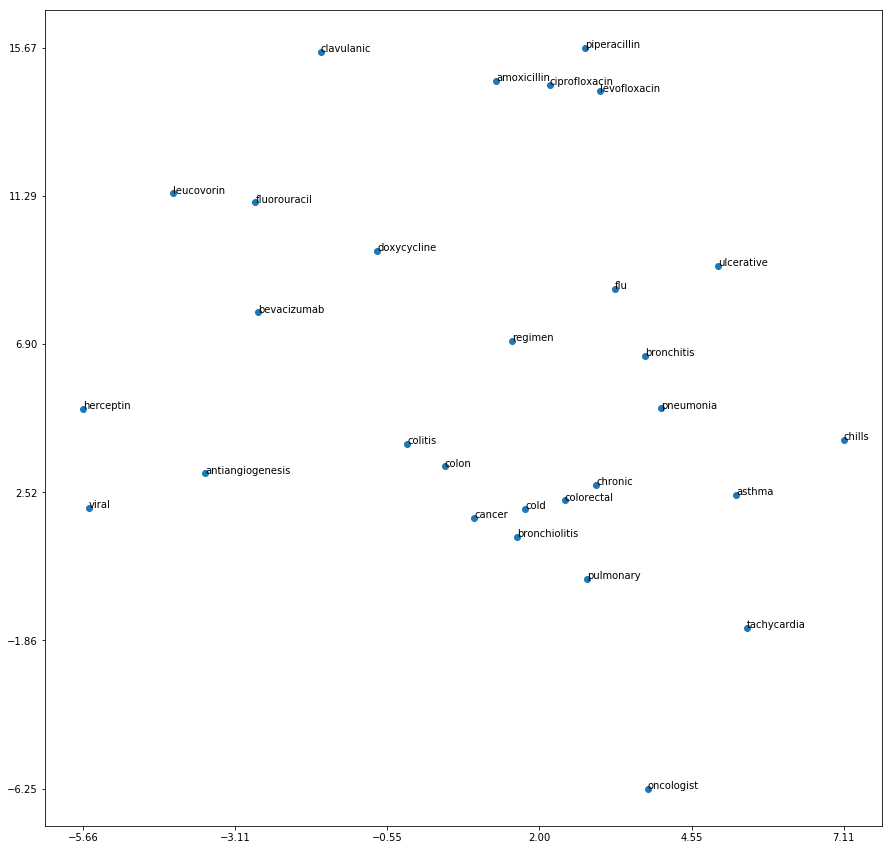

In [35]:
%%local
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
print(visualize_vectors.columns)

all_words = np.array(visualize_vectors.word)
all_vecs = np.array(visualize_vectors.pca_vector)

num_vectors = len(all_vecs)
vector_size = len(all_vecs[0]['values'])

print(num_vectors, vector_size)

all_vecs_new = []

for i in range(num_vectors):
    all_vecs_new.append(all_vecs[i]['values'])
    
Y = np.zeros(num_vectors)
for i in range(num_vectors):
    X[i] = all_vecs_new[i][0]
    Y[i] = all_vecs_new[i][1]

words = all_words

print(len(X), len(Y))
print(np.amin(X))
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X, Y)

xy_x = np.arange(np.amin(X), np.amax(X) + (np.amax(X) - np.amin(X))/5, (np.amax(X) - np.amin(X))/5)
xy_y = np.arange(np.amin(Y), np.amax(Y) +(np.amax(Y) - np.amin(Y))/5, (np.amax(Y) - np.amin(Y))/5)
plt.xticks(xy_x)
plt.yticks(xy_y)
for i, word in enumerate(words):
    ax.annotate(word, (X[i], Y[i]))


### Step 9

<b> For a better Visualization we use PCA + t-SNE</b>
<br> We first use PCA to reduce the dimensions to 45, then pick 15000 word vectors and apply t-SNE on them. We use the same word list for visualization as used in PCA (above) to see the differences between the 2 visualizations

In [36]:
from pyspark.ml.feature import PCA
pca = PCA(k=45, inputCol="features", outputCol="pca_vector")
model_pca = pca.fit(output)

print(model_pca.explainedVariance)
transformed = model_pca.transform(output).select("word", "pca_vector")

#REGISTER DF IN SQL-CONTEXT
transformed.createOrReplaceTempView("pca_tsne")
spark.sql("show tables").show()

[0.104391835775,0.0811255237652,0.0714619895395,0.0646699948814,0.0548719085746,0.0472854108528,0.0460593418285,0.0435659943174,0.0398821223037,0.0382154295432,0.0337891357566,0.0302435520328,0.0276145867491,0.0268183442174,0.0261740350193,0.0238030408324,0.0218380874616,0.0207995744426,0.0192600887465,0.0162211627006,0.0158925567937,0.013648767215,0.0129587378892,0.0121411912453,0.0114577180171,0.0106114000922,0.00960056243675,0.00852605689209,0.0075690971889,0.00674573670886,0.00651873782464,0.00607190214336,0.00584249491257,0.00502553208004,0.00496503715532,0.00360863615988,0.00324489334351,0.00267795009477,0.00243719120947,0.00199491767729,0.00183784375953,0.00151775967564,0.00140803131552,0.00124761935617,0.00106979686332]
+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
| default|   hivesampletable|      false|
|        |              dict|       true|
|        |               pca|       true|
|        |

In [37]:
%%sql -q -m take -n 15000 -o visualize_vectors_tsne
select p.word, p.pca_vector from pca_tsne p inner join visualization_dict vd on p.word = vd.test_words
union all
select pc.word, pc.pca_vector from pca_tsne pc

<b> Use t-SNE on 15000 words which include the words we plotted in PCA </b>
As you can see t-SNE in combination with PCA gives better visualization than only PCA. This is because PCA sufferes from a large information loss.

Index([u'word', u'pca_vector'], dtype='object')
(15000, 45)
colorectal
leucovorin
flu
pneumonia
amoxicillin
ulcerative
antiangiogenesis
pulmonary
asthma
piperacillin
herceptin
doxycycline
chills
bevacizumab
cold
ciprofloxacin
colon
cancer
colitis
oncologist
clavulanic
chronic
bronchiolitis
bronchitis
viral
regimen
tachycardia
fluorouracil
levofloxacin
29
(29, 29)


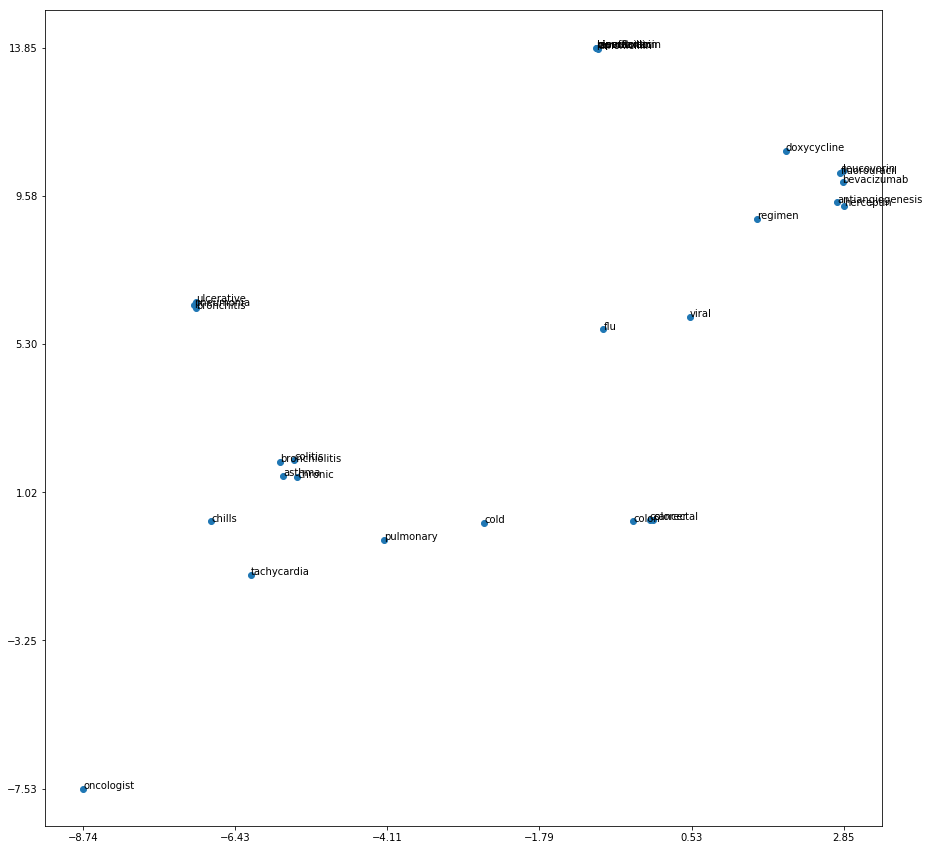

In [41]:
%%local
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print(visualize_vectors_tsne.columns)
dict_words = np.array(visualize_vectors.word)
all_words = np.array(visualize_vectors_tsne.word)
all_vecs = np.array(visualize_vectors_tsne.pca_vector)

num_vectors = len(all_vecs)
vector_size = len(all_vecs[0]['values'])

print(num_vectors, vector_size)
all_vecs_new = []
for i in range(num_vectors):
    all_vecs_new.append(all_vecs[i]['values'])
    
all_vecs_new = np.array(all_vecs_new)
tsne = TSNE(n_components = 2, init='pca', random_state=0)
all_vecs_new_TSNE = tsne.fit_transform(all_vecs_new, [num_vectors, vector_size])

X = []
Y = []
k = 0
seen = []
index = []
for i in range(num_vectors):
    for j in range(len(dict_words)):
        if dict_words[j] not in seen and dict_words[j] == all_words[i]:
            print(dict_words[j])
            seen.append(dict_words[j])
            X.append(all_vecs_new_TSNE[i][0])
            Y.append(all_vecs_new_TSNE[i][1])
            index.append(dict_words[j])
            k+=1
print(k)

X = np.array(X)
Y = np.array(Y)
words = np.array(index)
print(len(X), len(Y))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X, Y)

xy_x = np.arange(np.amin(X), np.amax(X) + (np.amax(X) - np.amin(X))/5, (np.amax(X) - np.amin(X))/5)
xy_y = np.arange(np.amin(Y), np.amax(Y) +(np.amax(Y) - np.amin(Y))/5, (np.amax(Y) - np.amin(Y))/5)

plt.xticks(xy_x)
plt.yticks(xy_y)
for i, word in enumerate(words):
    ax.annotate(word, (X[i], Y[i])) 


In [ ]:
%%sql -q -o sqlResultsPD
drop table word2vec

In [ ]:
%%sql -q -o sqlResultsPD
drop table visualization_dict